In [3]:
import sys
from pathlib import Path

# add src/ folder to Python path so we can import config
sys.path.append(str(Path.cwd().parents[0] / "src"))
import config as C

In [4]:
# Import basic libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, roc_auc_score
import config as C

# Load feature sets
X_first = pd.read_csv(C.PROC / "X_first.csv")
y_first = pd.read_csv(C.PROC / "y_first.csv").values.ravel()   # regression target
X_second = pd.read_csv(C.PROC / "X_second.csv")
y_second = pd.read_csv(C.PROC / "y_second.csv").values.ravel() # classification target

## Step 2: Train/Test Split

#### For Score Prediction (Regression)

In [5]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_first, y_first, test_size=0.2, random_state=42)

#### For Win Probability (Classification)

In [6]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_second, y_second, test_size=0.2, random_state=42, stratify=y_second)

🧠 Why:
	•	Splits 80 / 20 for unbiased testing.
	•	stratify ensures balanced win/loss classes.

## Step 3: Baseline Models

### Regression Model — Predict First-Innings Score

🧠 Meaning:
	•	Linear Regression predicts a continuous final score.
	•	MAE = average error in runs.
	•	R² = how much variance explained by model (closer to 1 = better).


In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(Xf_train, yf_train)

y_pred = reg.predict(Xf_test)

print("MAE:", mean_absolute_error(yf_test, y_pred))
print("R² Score:", r2_score(yf_test, y_pred))

MAE: 22.85073337297367
R² Score: -0.17891124395421243


### Classification Model — Win Probability

🧠 Meaning:
	•	Logistic Regression outputs a probability (0 – 1) for win % prediction.
	•	ROC-AUC ≈ 1 → model separates winners from losers well.
	•	predict_proba gives the “chance of winning”.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_second, y_second, test_size=0.2, random_state=42, stratify=y_second
)

clf = LogisticRegression(max_iter=500)
clf.fit(Xs_train, ys_train)

y_pred_cls = clf.predict(Xs_test)
y_pred_proba = clf.predict_proba(Xs_test)[:, 1]

print("Accuracy:", accuracy_score(ys_test, y_pred_cls))
print("ROC-AUC:", roc_auc_score(ys_test, y_pred_proba))

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [18]:
import numpy as np
import pandas as pd
import config as C

# Load saved FE datasets
X_second = pd.read_csv(C.PROC / "X_second.csv")
y_second = pd.read_csv(C.PROC / "y_second.csv").squeeze()

# Ensure correct dtypes (coerce any weird strings)
for c in X_second.columns:
    X_second[c] = pd.to_numeric(X_second[c], errors="coerce")

# Replace +/-inf with NaN
X_second.replace([np.inf, -np.inf], np.nan, inplace=True)

# Clip physically reasonable bounds (prevents extreme values)
# - runs_required: can't be negative
# - balls_left:    0..120
# - wickets_left:  0..10
# - crr, rrr:      keep in a sane range for T20 (0..36 runs/over)
bounds = {
    "runs_required": (0, None),
    "balls_left": (0, 120),
    "wickets_left": (0, 10),
    "crr": (0, 36),
    "rrr": (0, 36),
}
for col, (lo, hi) in bounds.items():
    if col in X_second.columns:
        if lo is not None: X_second[col] = X_second[col].clip(lower=lo)
        if hi is not None: X_second[col] = X_second[col].clip(upper=hi)

# Drop any remaining NaNs after coercion/clipping
mask_ok = X_second.notna().all(axis=1)
X_second = X_second.loc[mask_ok].reset_index(drop=True)
y_second = y_second.loc[mask_ok].reset_index(drop=True)

print("After cleaning:", X_second.shape, "Any inf?", np.isinf(X_second.values).any(), 
      "Any NaN?", np.isnan(X_second.values).any())

After cleaning: (72043, 5) Any inf? False Any NaN? False


In [20]:
assert np.isfinite(X_second.values).all(), "X_second still has non-finite values"
assert y_second.isin([0,1]).all(), "y_second must be 0/1 only"

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_second, y_second, test_size=0.2, random_state=42, stratify=y_second
)

# A solver that often behaves well on small/medium numeric sets
clf = LogisticRegression(max_iter=1000, solver="lbfgs")
clf.fit(Xs_train, ys_train)

y_pred_cls = clf.predict(Xs_test)
y_pred_proba = clf.predict_proba(Xs_test)[:, 1]

print("Accuracy:", accuracy_score(ys_test, y_pred_cls))
print("ROC-AUC:", roc_auc_score(ys_test, y_pred_proba))

Accuracy: 0.7865223124436116
ROC-AUC: 0.8756229298586751


In [24]:
print("Non-finite by column:")
print(pd.DataFrame({
    "has_nan": X_second.isna().any(),
    "has_inf": X_second.apply(lambda s: np.isinf(s).any())
}))

# Find and show a few bad rows if any reappear
bad = ~np.isfinite(X_second.values).all(axis=1) if hasattr(np, "isfinite") else None
if bad is not None and bad.any():
    display(X_second[bad].head(10))

Non-finite by column:
               has_nan  has_inf
runs_required    False    False
balls_left       False    False
wickets_left     False    False
crr              False    False
rrr              False    False


In [26]:
# add to your X_second before split (or make a copy and re-split)
X_second_ext = X_second.copy()
X_second_ext["crr_minus_rrr"] = X_second_ext["crr"] - X_second_ext["rrr"]

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_second_ext, y_second, test_size=0.2, random_state=42, stratify=y_second
)

clf = LogisticRegression(max_iter=1000, solver="lbfgs")
clf.fit(Xs_train, ys_train)
y_proba = clf.predict_proba(Xs_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(ys_test, y_pred))
print("ROC-AUC:", roc_auc_score(ys_test, y_proba))

Accuracy: 0.7865223124436116
ROC-AUC: 0.8756226398518352


In [28]:
coef = pd.Series(clf.coef_[0], index=Xs_train.columns).sort_values()
display(coef.to_frame("coef"))

,coef
rrr,-0.189868
crr,-0.062778
runs_required,-0.027341
balls_left,0.004947
crr_minus_rrr,0.127090
wickets_left,0.542619


In [32]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import brier_score_loss

base = LogisticRegression(max_iter=1000, solver="lbfgs")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cal = CalibratedClassifierCV(estimator=base, method="isotonic", cv=cv)  # <-- changed here
cal.fit(Xs_train, ys_train)

proba_cal = cal.predict_proba(Xs_test)[:, 1]

print("Brier score (lower better):", brier_score_loss(ys_test, proba_cal))
print("ROC-AUC (calibrated):", roc_auc_score(ys_test, proba_cal))

Brier score (lower better): 0.14341009390550957
ROC-AUC (calibrated): 0.8756635211493675


In [34]:
import joblib, datetime, os
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
fname = f"winprob_logreg_calibrated_{timestamp}.pkl"
path = C.PROC / fname
joblib.dump(cal, path)
print("Saved:", path)

Saved: /Users/vijay/Documents/G2i/ML Project/cricket-winprob/data/processed/winprob_logreg_calibrated_20251013_1819.pkl


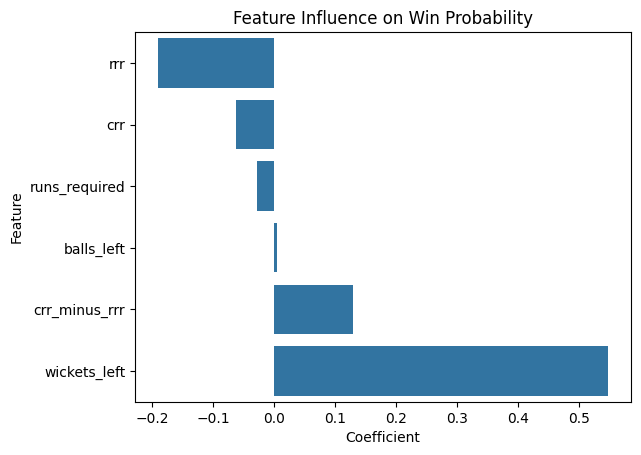

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Each fold in CalibratedClassifierCV has its own fitted estimator
# We'll take the first one (they’re usually very similar)
inner_model = cal.calibrated_classifiers_[0].estimator

# Extract coefficients
coef = pd.Series(inner_model.coef_[0], index=Xs_train.columns).sort_values()

# Plot feature influence
sns.barplot(x=coef.values, y=coef.index)
plt.title("Feature Influence on Win Probability")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

In [50]:
# --- First-innings regression baseline ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib, config as C

X_first = pd.read_csv(C.PROC / "X_first.csv")
y_first = pd.read_csv(C.PROC / "y_first.csv").squeeze()

Xf_tr, Xf_te, yf_tr, yf_te = train_test_split(X_first, y_first, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=500, min_samples_leaf=2, random_state=42, n_jobs=-1)
reg.fit(Xf_tr, yf_tr)
yhat = reg.predict(Xf_te)

print("MAE (runs):", mean_absolute_error(yf_te, yhat))
print("R²:", r2_score(yf_te, yhat))

joblib.dump(reg, C.PROC / "score_rf.pkl")

MAE (runs): 21.272800410093367
R²: -0.0325163699758344


['/Users/vijay/Documents/G2i/ML Project/cricket-winprob/data/processed/score_rf.pkl']

In [52]:
# add once in FE or here before split
def phase_from_balls_left(b):
    if b >= 84:  return "PP"     # overs 1-6
    if b >= 30:  return "MID"    # overs 7-15
    return "DEATH"               # overs 16-20

X_second_ext = X_second.copy()
X_second_ext["phase"] = Xs_train.assign(phase= Xs_train["balls_left"].apply(phase_from_balls_left))["phase"]
# one-hot encode phase if you want to keep LogisticRegression simple
X_second_ext = pd.get_dummies(X_second_ext, columns=["phase"], drop_first=True)

In [54]:
import json, config as C
with open(C.PROC / "winprob_features.json", "w") as f:
    json.dump(list(Xs_train.columns), f)
with open(C.PROC / "score_features.json", "w") as f:
    json.dump(list(Xf_tr.columns), f)

In [56]:
# Win prob inference
def predict_win_prob(cal_model, feature_order, row_dict):
    import numpy as np
    x = np.array([row_dict[c] for c in feature_order], dtype=float).reshape(1,-1)
    return float(cal_model.predict_proba(x)[:,1])

# Score inference (first innings, match-level categorical already encoded)
def predict_score(reg_model, feature_order, row_dict):
    import numpy as np
    x = np.array([row_dict[c] for c in feature_order], dtype=float).reshape(1,-1)
    return float(reg_model.predict(x)[0])

In [66]:
import json, config as C
import pandas as pd

# for win probability
X_second = pd.read_csv(C.PROC / "X_second.csv")
with open("models/winprob_features.json", "w") as f:
    json.dump(list(X_second.columns), f)

# for first-innings score
X_first = pd.read_csv(C.PROC / "X_first.csv")
with open("models/score_features.json", "w") as f:
    json.dump(list(X_first.columns), f)

print("Saved feature schemas to models/")

FileNotFoundError: [Errno 2] No such file or directory: 'models/winprob_features.json'